In [1]:
import pandas as pd
import serial
#opcua
from asyncua import Client, Node, ua
import asyncio
#utils
import time
import math

## Connect to plc and log data

In [ ]:
# n_Flowrate_set = plc.get_node("ns=3;s=\"PLC DB\".\"Flowrate_set\"")  ##PID set_point
# n_Pressure = plc.get_node("ns=3;s=\"PLC DB\".\"Flowrate\"")  ##Pressure actual feedback
# n_Pressure = plc.get_node("ns=3;s=\"PLC DB\".\"Pressure_manual\"") ## manual pressure set value in psi
# n_Pressure = plc.get_node("ns=3;s=\"PLC DB\".\"PID manual\"") ## turn on maunual control of PID


In [2]:
url = "opc.tcp://192.168.0.1:4840"
plc = Client(url)
await plc.connect()
# n_rtd = plc.get_node("ns=3;s=\"PLC DB\".\"RTD\"")
n_Flowrate = plc.get_node("ns=3;s=\"PLC DB\".\"Flowrate\"")
n_Pressure = plc.get_node("ns=3;s=\"PLC DB\".\"Pressure\"")
n_Pressure_set = plc.get_node("ns=3;s=\"PLC DB\".\"Pressure_set\"")
n_Flowrate_set = plc.get_node("ns=3;s=\"PLC DB\".\"Flowrate_set\"")

Requested session timeout to be 3600000ms, got 30000ms instead


In [3]:
counter = 0
df = pd.DataFrame(columns = ['time','flowrate_set','flowrate','pressure_set','pressure'])
while counter < 600:
    counter += 1
    target = await n_Flowrate_set.get_value()
    flowrate = await n_Flowrate.get_value()
    pressure_set = await n_Pressure_set.get_value()
    pressure = await n_Pressure.get_value()
    df.loc[counter] = [counter*0.1,target,flowrate,pressure_set,pressure]
    time.sleep(0.1)
df.to_csv('dft1.0d.csv')  

## Plotting

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set(rc={"figure.figsize":(12, 8)})

### Plottting response of different controllers

In [7]:
df1 = pd.read_csv('dft1.0.csv'.format(0.5+0.5*i)).drop(columns=['Unnamed: 0']).set_index('time') #p1.0 ti 0.7
df2 = pd.read_csv('dft1.0n.csv'.format(0.5+0.5*i)).drop(columns=['Unnamed: 0']).set_index('time') #p0.3 ti 0.7
df3 = pd.read_csv('dft1.0b.csv'.format(0.5+0.5*i)).drop(columns=['Unnamed: 0']).set_index('time') #p0.6 ti 0.7
df4 = pd.read_csv('dft1.0c.csv'.format(0.5+0.5*i)).drop(columns=['Unnamed: 0']).set_index('time') #p0.6 ti 1.2
df5 = pd.read_csv('dft1.0d.csv'.format(0.5+0.5*i)).drop(columns=['Unnamed: 0']).set_index('time') #p0.6 ti 0.4
dft = [df1,df2,df3,df4,df5]

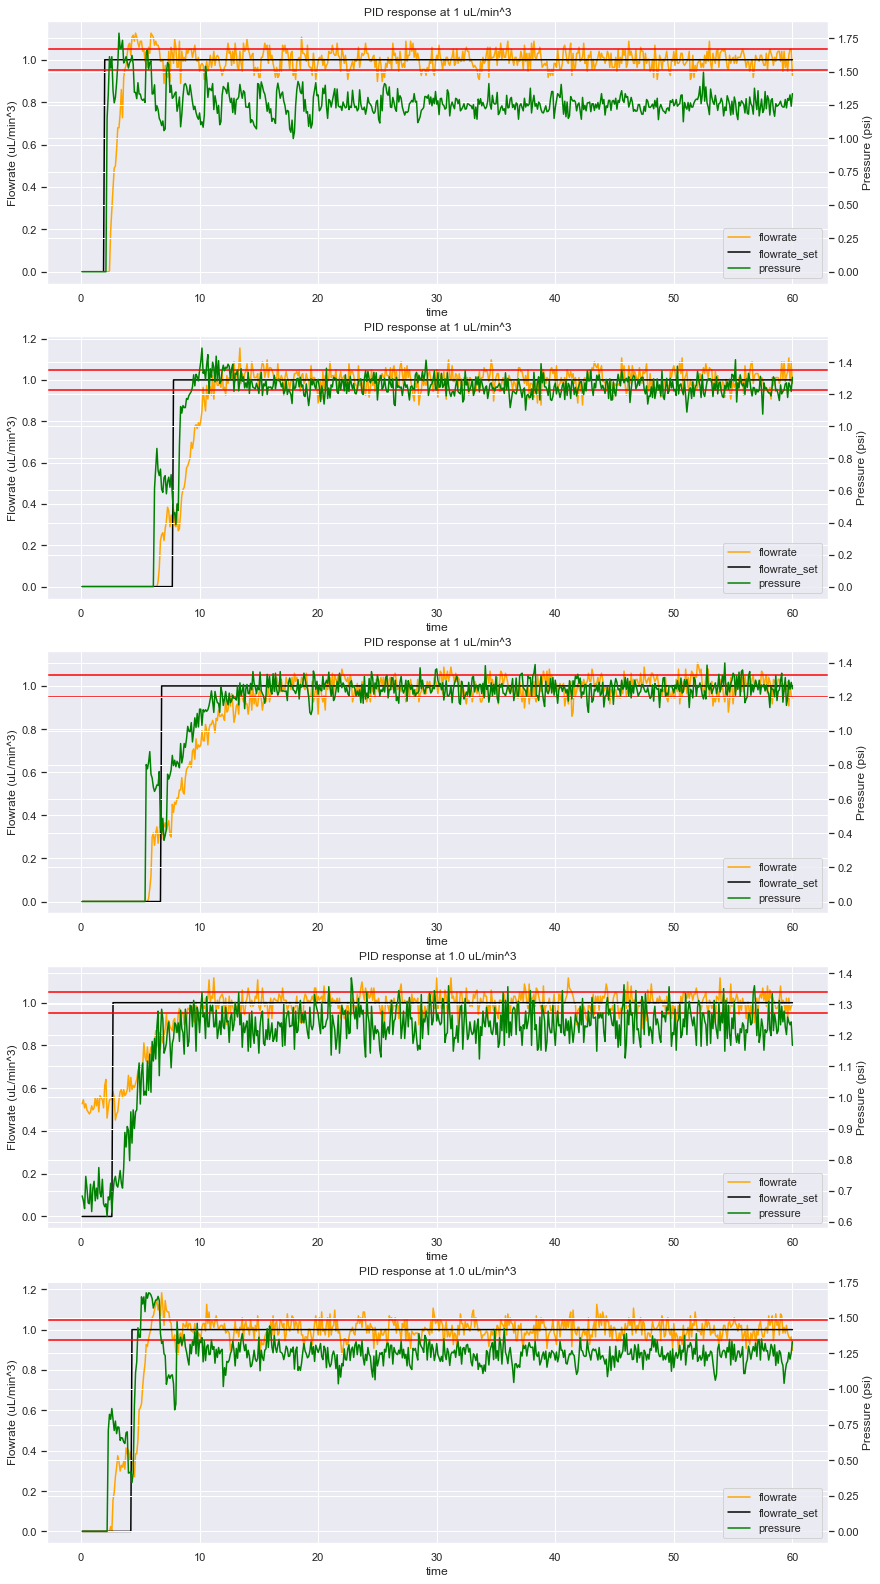

Error while renewing session
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\envs\siemens\lib\asyncio\tasks.py", line 456, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\envs\siemens\lib\site-packages\asyncua\client\client.py", line 424, in _renew_channel_loop
    await self.open_secure_channel(renew=True)
  File "C:\Users\Administrator\anaconda3\envs\siemens\lib\site-packages\asyncua\client\client.py", line 317, in open_secure_channel
    result = await self.uaclient.open_secure_channel(params)
  File "C:\Users\Administrator\anaconda3\envs\siemens\lib\site-packages\asyncua\client\ua_client.py", line 281, in open_secure_channel
    return await self.protocol.open_secure_channel(params)
  File "C:\Users\Administrator\anaconda3\envs\siemens\lib\site-packages\asyncua\client\ua_client.py", line 

In [11]:
fig, axes = plt.subplots(5, 1, figsize=(14, 28))
for i in range(5):
    sns.lineplot(data=dft[i]['flowrate'],ax=axes[i],color='orange', label = 'flowrate',legend=False)
    sns.lineplot(data=dft[i]['flowrate_set'],ax=axes[i],color='black', label = 'flowrate_set',legend=False,sizes=3)
    setpoint = dft[i]['flowrate_set'].iloc[500]
    ax2 = axes[i].twinx()
    sns.lineplot(data=dft[i]['pressure'],ax=ax2,color='green', label = 'pressure')
    #     sns.lineplot(data=dft[i]['pressure_set'],ax=ax2,color='darkgreen',sizes=0.2)
    ax=axes[i].axhline(setpoint*(1+0.05), 0,6 ,color='red')
    ax=axes[i].axhline(setpoint*(1-0.05), 0,6 ,color='red')
    axes[i].set_ylabel('Flowrate (uL/min^3)')
    ax2.set_ylabel('Pressure (psi)')
    #     axes[int(i/2),int(i%2)].legend(['flowrate','flowrate_set'],loc=4)
    #     ax2.legend(['Pressure'],loc=4)
    lines, labels = axes[i].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=4)
    ax2.set_title(f'PID response at {setpoint} uL/min^3')

### Plotting response of 1 controller at different setpoints

In [5]:
df = []
for i in range(10):
    df.append(pd.read_csv('dft{:0.1f}.csv'.format(0.5+0.5*i)).drop(columns=['Unnamed: 0']).set_index('time'))

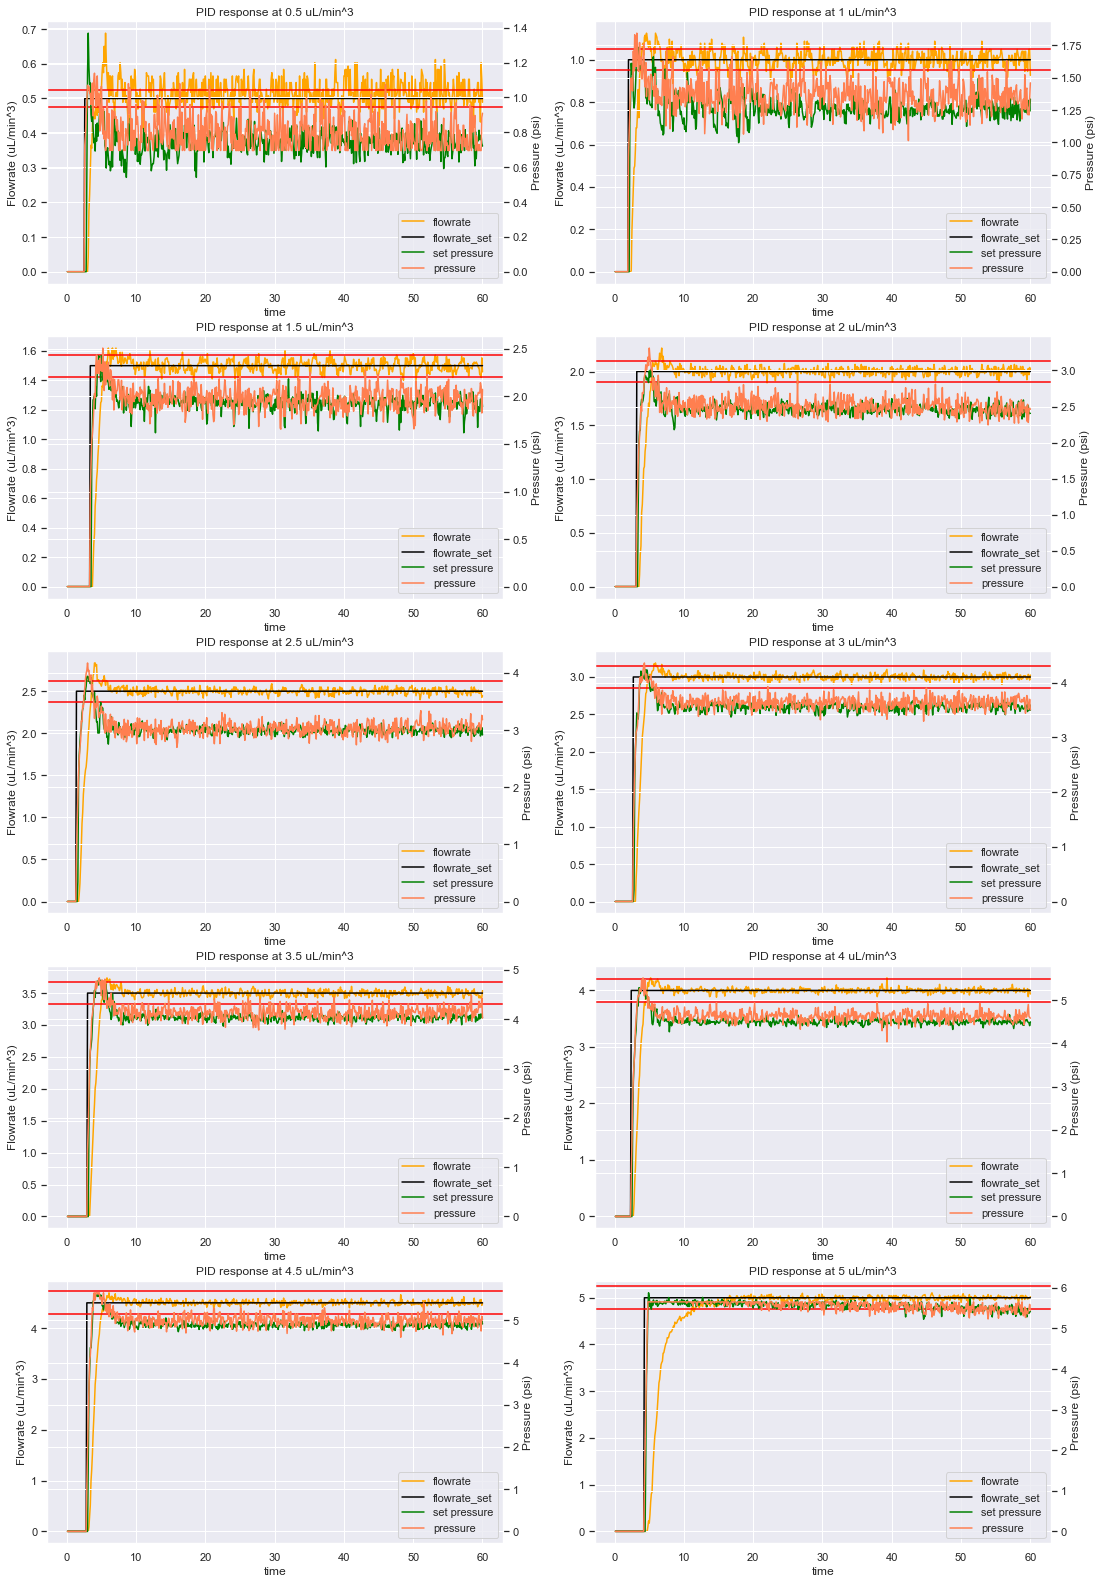

In [13]:
fig, axes = plt.subplots(5, 2, figsize=(18, 28))
for i in range(10):
    sns.lineplot(data=df[i]['flowrate'],ax=axes[int(i/2),int(i%2)],color='orange', label = 'flowrate',legend=False)
    sns.lineplot(data=df[i]['flowrate_set'],ax=axes[int(i/2),int(i%2)],color='black', label = 'flowrate_set',legend=False,sizes=3)
    setpoint = df[i]['flowrate_set'].iloc[500]
    ax2 = axes[int(i/2),int(i%2)].twinx()
    sns.lineplot(data=df[i]['pressure'],ax=ax2,color='green', label = 'set pressure')
    sns.lineplot(data=df[i]['pressure_set'],ax=ax2,color='coral',label = 'pressure',sizes=0.2)
    ax=axes[int(i/2),int(i%2)].axhline(setpoint*(1+0.05), 0,6 ,color='red')
    ax=axes[int(i/2),int(i%2)].axhline(setpoint*(1-0.05), 0,6 ,color='red')
    axes[int(i/2),int(i%2)].set_ylabel('Flowrate (uL/min^3)')
    ax2.set_ylabel('Pressure (psi)')
#     axes[int(i/2),int(i%2)].legend(['flowrate','flowrate_set'],loc=4)
#     ax2.legend(['Pressure'],loc=4)
    lines, labels = axes[int(i/2),int(i%2)].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=4)
    ax2.set_title(f'PID response at {setpoint} uL/min^3')